<a href="https://colab.research.google.com/github/ravitiwari8877/ravitiwari8877/blob/main/MultiClass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import tensorflow as tf
import open3d as o3d

In [ ]:
!pip install Open3D

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the CSV files
powerline1 = pd.read_csv('/content/drive/MyDrive/Power LIne/Dataset/power1.csv')
powerline2 = pd.read_csv('/content/drive/MyDrive/Power LIne/Dataset/power2.csv')
powerline3 = pd.read_csv('/content/drive/MyDrive/Power LIne/Dataset/power3.csv')
powerline4 = pd.read_csv('/content/drive/MyDrive/Power LIne/Dataset/power4.csv')
powerline5 = pd.read_csv('/content/drive/MyDrive/Power LIne/Dataset/power5.csv')

veg1 = pd.read_csv('/content/drive/MyDrive/Power LIne/Dataset/vegs.csv')

building3 = pd.read_csv('/content/drive/MyDrive/Power LIne/Dataset/buildingss.csv')

In [ ]:
def preprocess_point_cloud(points, voxel_size):
    
    x = points['X']
    y = points['Y']
    z = points['Z']
    point = np.array([x,y, z]).T
    
    # Convert to Open3D point cloud format
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(point)

    #print(":: Downsample with a voxel size %.3f." % voxel_size)
    pcd_down = pcd.voxel_down_sample(voxel_size)

    radius_normal = voxel_size * 2
    #print(":: Estimate normal with search radius %.3f." % radius_normal)
    pcd_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))

    radius_feature = voxel_size * 5
    #print(":: Compute FPFH feature with search radius %.3f." % radius_feature)
    pcd_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
        pcd_down,
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100))
    return pcd_down, pcd_fpfh

In [ ]:
def ready_data(pcd_down,pcd_fpfh,Class):
    xyz = np.asarray(pcd_down.points)  # Convert points to numpy array

    fpfh=pcd_fpfh.data.T

    normals=np.asarray(pcd_down.normals)

    # Convert x,y,z and normals to a pandas DataFrame
    data = pd.DataFrame({'x': xyz[:, 0], 'y': xyz[:, 1], 'z': xyz[:, 2], 'nx': normals[:,0], 'ny': normals[:,1], 'nz': normals[:,2]})

    # Concatenate data with FPFH
    features = np.concatenate((data.to_numpy(), fpfh), axis=1)

    # Convert array to dataframe
    data_df = pd.DataFrame(features, columns=['X', 'Y', 'Z', 'nx','ny','nz','F0','F1','F2','F3','F4','F5','F6','F7','F8','F9','F10','F11','F12','F13','F14','F15','F16','F17','F18','F19','F20','F21','F22','F23','F24','F25','F26','F27','F28','F29','F30','F31','F32'])
    
    #np.zeros(len(powerline)).astype(int)
    #np.ones(len(veg)).astype(int)
    #np.full(len(building), 2).astype(int)
    
    data_df['Class'] = np.full(len(data_df),Class).astype(int)
    return data_df

In [ ]:
powerline1_down, powerline1_fpfh= preprocess_point_cloud(powerline1, 0.3)
powerline2_down, powerline2_fpfh= preprocess_point_cloud(powerline2, 0.3)
powerline3_down, powerline3_fpfh= preprocess_point_cloud(powerline3, 0.3)
powerline4_down, powerline4_fpfh= preprocess_point_cloud(powerline4, 0.3)
powerline5_down, powerline5_fpfh= preprocess_point_cloud(powerline5, 0.3)

veg_down, veg_fpfh= preprocess_point_cloud(veg1, 0.4)

building_down, building_fpfh= preprocess_point_cloud(building3, 0.4)

In [ ]:
power1 = ready_data(powerline1_down, powerline1_fpfh,0)
power2 = ready_data(powerline2_down, powerline2_fpfh,0)
power3 = ready_data(powerline3_down, powerline3_fpfh,0)
power4 = ready_data(powerline4_down, powerline4_fpfh,0)
power5 = ready_data(powerline5_down, powerline5_fpfh,0)

In [ ]:
veg =ready_data(veg_down, veg_fpfh,1)

In [ ]:
building =ready_data(building_down, building_fpfh,2)

In [ ]:
data_train  = pd.concat([power1,power2,power3,power4,power5,veg,building])

In [ ]:
data_train.head()

,X,Y,Z,nx,ny,nz,F0,F1,F2,F3,...,F24,F25,F26,F27,F28,F29,F30,F31,F32,Class
0,361.660,30.52,15.33,0.892757,-0.421210,-0.159897,9.315774,8.991230,21.539678,26.058858,...,14.822488,31.233222,12.078695,11.283015,25.233348,26.984348,30.613933,21.975164,11.623891,0
1,361.740,30.56,13.28,0.091763,0.680289,-0.727177,13.557106,19.405250,7.670107,4.629162,...,20.112080,5.604773,12.398917,5.313398,35.629126,25.809485,19.256194,0.971620,31.020389,0
2,361.540,31.55,16.01,-0.097727,0.248340,-0.963731,22.394097,4.318091,5.360446,3.581972,...,28.665014,45.592182,54.300361,16.546607,13.858530,16.364334,8.126774,5.616224,1.750238,0
3,361.800,30.52,16.17,-0.705174,-0.029134,-0.708436,8.058281,5.677768,8.846587,13.545920,...,27.940957,44.866788,10.803551,8.366084,17.745219,21.318723,23.554385,15.968840,6.906314,0
4,361.875,30.43,11.37,-0.476537,0.429653,-0.767015,27.329732,21.893852,15.031936,3.101545,...,23.582288,13.570710,27.833187,2.526582,32.103193,4.792670,4.384233,16.220193,26.815179,0


In [ ]:
# How many category in target
data_train['Class'].value_counts()

1    354534
2    296187
0    260716
Name: Class, dtype: int64

In [ ]:
X = data_train.drop('Class',axis =1)
Y= data_train['Class']

In [ ]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 1,stratify=Y)

In [ ]:
X_train.shape, X_test.shape,Y_train.shape

((729149, 39), (182288, 39), (729149,))

In [ ]:
import tensorflow as tf

model = tf.keras.Sequential([
    # Hidden Layer   (units = no of input(39) + no of output(3))
    tf.keras.layers.Dense(units= 41, activation = 'relu',input_dim = 39),
    # output layers
    tf.keras.layers.Dense(units =3, activation = 'softmax')
])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 41)                1640      
                                                                 
 dense_3 (Dense)             (None, 3)                 126       
                                                                 
Total params: 1,766
Trainable params: 1,766
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
# create a procedure for EARLY STOPING
# calling inbuilt class:   EarlyStopping

from tensorflow.keras.callbacks import EarlyStopping

#create object  
cb = EarlyStopping(monitor = 'val_loss',   # Mention parameter to monitor .. it may me loss or score
                   min_delta = 0.0001,     # diff btw new and previous loss: bydefault we take 0.0001
                   patience = 20,          
                   verbose =1,
                   mode = 'auto',
                   baseline = None,
                   restore_best_weights =False)

In [ ]:
# train the model: use inbuilt method fit() of Sequential class

train_model = model.fit(X_train, Y_train,epochs =5000,validation_data= (X_test, Y_test), callbacks = cb, batch_size = 64)
# validation_split = 0.2 :: It is used when ever you do not have output data in test file. In this case
# we are using 20% of train data to test the model

Epoch 1/5000
11393/11393 [==============================] - 44s 4ms/step - loss: 0.8395 - accuracy: 0.8026 - val_loss: 0.5161 - val_accuracy: 0.8172
Epoch 2/5000
11393/11393 [==============================] - 41s 4ms/step - loss: 0.4320 - accuracy: 0.8433 - val_loss: 0.3910 - val_accuracy: 0.8577
Epoch 3/5000
11393/11393 [==============================] - 41s 4ms/step - loss: 0.3823 - accuracy: 0.8603 - val_loss: 0.3782 - val_accuracy: 0.8576
Epoch 4/5000
11393/11393 [==============================] - 41s 4ms/step - loss: 0.3556 - accuracy: 0.8685 - val_loss: 0.3374 - val_accuracy: 0.8764
Epoch 5/5000
11393/11393 [==============================] - 41s 4ms/step - loss: 0.3331 - accuracy: 0.8751 - val_loss: 0.3113 - val_accuracy: 0.8833
Epoch 6/5000
11393/11393 [==============================] - 41s 4ms/step - loss: 0.3152 - accuracy: 0.8821 - val_loss: 0.3091 - val_accuracy: 0.8861
Epoch 7/5000
11393/11393 [==============================] - 41s 4ms/step - loss: 0.3019 - accuracy: 0.8872

In [ ]:
# Here we see that out model is Underfit ....No we will increse the no of Hidden layer
print("Traning Loss and Accuracy ", model.evaluate(X_train, Y_train))
print("Testing Loss and Accuracy: ", model.evaluate(X_test, Y_test))

22786/22786 [==============================] - 71s 3ms/step - loss: 0.2674 - accuracy: 0.9027
Traning Loss and Accuracy  [0.2674034535884857, 0.9026824235916138]
5697/5697 [==============================] - 14s 3ms/step - loss: 0.2705 - accuracy: 0.9017
Testing Loss and Accuracy:  [0.27054673433303833, 0.9017049670219421]


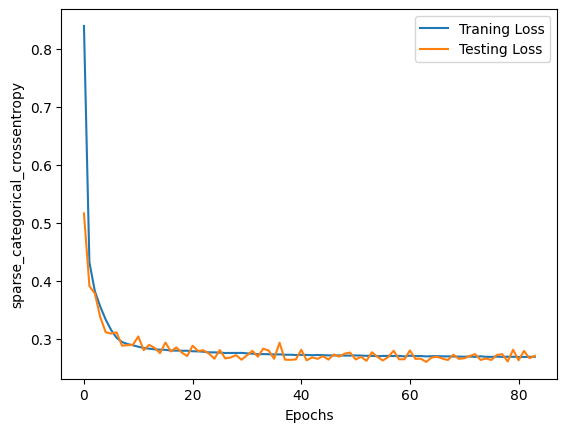

In [ ]:
# Visulisation
plt.plot(train_model.history['loss'],label = 'Traning Loss')
plt.plot(train_model.history['val_loss'],label = 'Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('sparse_categorical_crossentropy')
plt.legend()
plt.show()

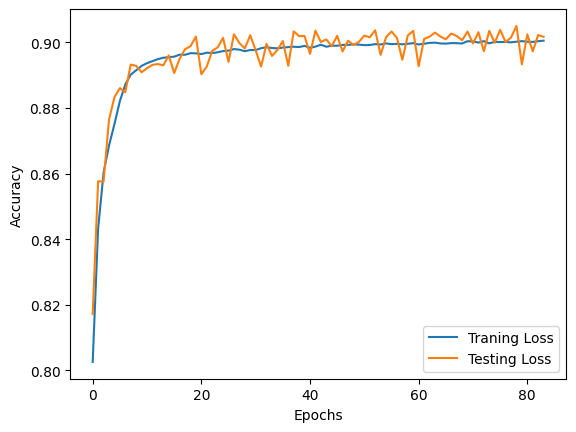

In [ ]:
# Visulisation
plt.plot(train_model.history['accuracy'],label = 'Traning Loss')
plt.plot(train_model.history['val_accuracy'],label = 'Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import regularizers
model1 = tf.keras.Sequential([
    # Hidden Layer   (units = no of input(47) + no of output(3))
    tf.keras.layers.Dense(units= 41, activation = 'relu',input_dim = 39,
                          kernel_regularizer =regularizers.l2(0.01)),
    # output layers
    tf.keras.layers.Dense(units =3, activation = 'softmax',kernel_regularizer =regularizers.l2(0.01))
])

In [ ]:
model1.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
train_model = model1.fit(X_train, Y_train,epochs =50,validation_data= (X_test, Y_test), callbacks = cb, batch_size = 64)

Epoch 1/50
11393/11393 [==============================] - 48s 4ms/step - loss: 0.7830 - accuracy: 0.8190 - val_loss: 0.4802 - val_accuracy: 0.8528
Epoch 2/50
11393/11393 [==============================] - 49s 4ms/step - loss: 0.4555 - accuracy: 0.8517 - val_loss: 0.4172 - val_accuracy: 0.8591
Epoch 3/50
11393/11393 [==============================] - 48s 4ms/step - loss: 0.4177 - accuracy: 0.8599 - val_loss: 0.4137 - val_accuracy: 0.8579
Epoch 4/50
11393/11393 [==============================] - 44s 4ms/step - loss: 0.4001 - accuracy: 0.8647 - val_loss: 0.3888 - val_accuracy: 0.8684
Epoch 5/50
11393/11393 [==============================] - 45s 4ms/step - loss: 0.3958 - accuracy: 0.8656 - val_loss: 0.3960 - val_accuracy: 0.8664
Epoch 6/50
11393/11393 [==============================] - 44s 4ms/step - loss: 0.3927 - accuracy: 0.8668 - val_loss: 0.3818 - val_accuracy: 0.8696
Epoch 7/50
11393/11393 [==============================] - 47s 4ms/step - loss: 0.3916 - accuracy: 0.8669 - val_loss: 0

In [ ]:
# Here we see that out model is Underfit ....No we will increse the no of Hidden layer
print("Traning Loss and Accuracy: ", model1.evaluate(X_train, Y_train))
print("Testing Loss and Accuracy: ", model1.evaluate(X_test, Y_test))

22786/22786 [==============================] - 70s 3ms/step - loss: 0.3845 - accuracy: 0.8682
Traning Loss and Accuracy:  [0.38449960947036743, 0.8681737184524536]
5697/5697 [==============================] - 15s 3ms/step - loss: 0.3848 - accuracy: 0.8675
Testing Loss and Accuracy:  [0.38481995463371277, 0.8675118684768677]


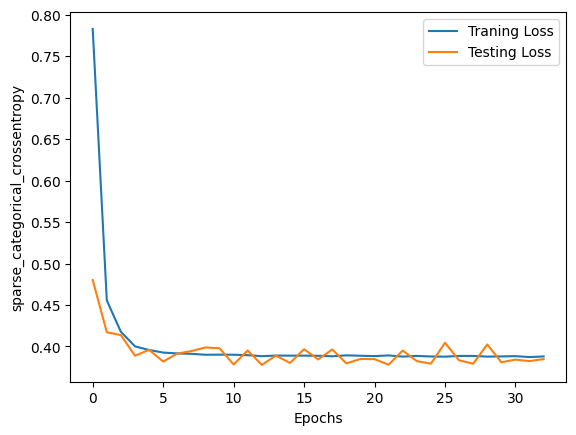

In [ ]:
# Visulisation
plt.plot(train_model.history['loss'],label = 'Traning Loss')
plt.plot(train_model.history['val_loss'],label = 'Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('sparse_categorical_crossentropy')
plt.legend()
plt.show()
     

In [ ]:
# Visulisation
plt.plot(train_model1.history['accuracy'],label = 'Traning Loss')
plt.plot(train_model1.history['val_accuracy'],label = 'Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

NameError: ignored

In [ ]:
# To load test file 
data_test = pd.read_csv('/content/drive/MyDrive/Power LIne/test.csv')

In [ ]:
data_test.head()

,X,Y,Z,Intensity,Class
0,260.14,362.65,11.98,18131,8
1,259.00,362.93,11.83,13150,8
2,261.32,362.33,12.13,0,8
3,260.72,362.48,12.03,6684,8
4,259.59,362.75,9.89,0,8


In [ ]:
grouped = data_test.groupby("Class")

In [ ]:
powerline_down, powerline1_fpfh= preprocess_point_cloud(grouped.get_group(5), 0.3)
powerline7_down, powerline2_fpfh= preprocess_point_cloud(grouped.get_group(7), 0.3)


veg_down, veg_fpfh= preprocess_point_cloud(grouped.get_group(2), 0.4)

building_down, building_fpfh= preprocess_point_cloud(grouped.get_group(8), 0.4)

In [ ]:
power_1 = ready_data(powerline_down, powerline1_fpfh,0)
power_2 = ready_data(powerline7_down, powerline2_fpfh,0)
veg_ =ready_data(veg_down, veg_fpfh,1)
building_ =ready_data(building_down, building_fpfh,2)

In [ ]:
data_test  = pd.concat([power1,power2,veg_,building_])

In [ ]:
X_test_ =data_test.drop('Class',axis=1)
Y_test_ = data_test['Class']

# Make a copy
X_test2 = X_test_

In [ ]:
# prediction
from sklearn.metrics import classification_report
Y_pred = model.predict(X_test2)


62347/62347 [==============================] - 103s 2ms/step


In [ ]:
Y_pred.round(2)

array([[0.13, 0.8 , 0.07],
       [0.06, 0.9 , 0.03],
       [0.2 , 0.72, 0.08],
       ...,
       [0.13, 0.72, 0.15],
       [0.  , 0.53, 0.47],
       [0.84, 0.01, 0.15]], dtype=float32)

In [ ]:
Y_pred = [np.argmax(i) for i in Y_pred]

In [ ]:
Y_pred1 = []
for i in Y_pred:
  if i == 0:
    Y_pred1.append('Power')
  elif i ==1:
    Y_pred1.append('Veg')
  else:
    Y_pred1.append('Building')

In [ ]:
data_test['Class_pred'] = Y_pred1

In [ ]:
data_test = data_test[['X','Y','Z', 'Class_pred']]

In [ ]:
data_test.to_csv('result123.csv', index =False)  # to save Data in csv

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(Y_test_,Y_pred))

              precision    recall  f1-score   support

           0       0.57      0.83      0.68    115903
           1       0.81      0.96      0.88   1294241
           2       0.92      0.43      0.59    584952

    accuracy                           0.80   1995096
   macro avg       0.76      0.74      0.72   1995096
weighted avg       0.82      0.80      0.78   1995096



In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(Y_test_,Y_pred))

[[  96522   13831    5550]
 [  28810 1247905   17526]
 [  43509  287086  254357]]


In [ ]:
x = data_test.X
y = data_test.Y
z = data_test.Z
import open3d as o3d
points = np.asarray([x,y,z]).T

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
o3d.visualization.draw_geometries([pcd])

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


In [ ]:
Y_pred = model1.predict(X_test2)

62347/62347 [==============================] - 101s 2ms/step


In [ ]:
/content/result123.csv

In [ ]:
model1.save('classification.h5')

In [ ]:
model1.save_weights('class_weight.h5')